## **Import Libraries**

In [4]:
import pandas as pd 
import os
import cv2
import matplotlib.pyplot as plt
import pylab
import numpy as np
import torch
import torchvision
from torchvision import transforms, datasets
from torch.utils.data import Dataset
import PIL

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


## **Preparing Dataset for task 2**

**Data Preprocessing:**

In [3]:
# specify paths 
label_file = '..\CelebA\Anno\identity_CelebA.txt'
img_dir = '..\CelebA\Img\img_align_celeba\img_align_celeba'
output_dir = '..\\task2_data'

os.makedirs(output_dir, exist_ok=True)

# load labels file
data= pd.read_csv(label_file, sep=' ', header=None, names=['img', 'id'])

# mean_value of images for each label
mean_count = data['id'].value_counts().mean()

# selecting 50 unique entries having examples more than mean_count
selected_ids = [id for id,count in data['id'].value_counts().items() if count>mean_count][0:50]

# selecting 5 images for each selected_ids
new_data = pd.DataFrame(columns = ['id', 'img'])

for id in selected_ids: 
  mask = data['id'] == id
  new_data = new_data.append(data[mask][0:5])

# adding label coloumn
new_data = new_data.merge(new_data, how='cross')
new_data['label'] = new_data['id_x'] == new_data['id_y']
label_map = {True : 1, False : 0}
new_data["label"] = new_data["label"].map(label_map)

# seperating label1 and 0 data
label_1_data = new_data[new_data["label"] ==1]
label_0_data = new_data[new_data["label"] ==0]

# droping values from label 0 data so that both label 1 and 0 have equal examples
label_0_data = label_0_data[::50]

# merging label 1 and 0 data and saving a csv file 

final_data = pd.concat([label_1_data, label_0_data], ignore_index=True, sort=False)

final_data.to_csv(os.path.join(output_dir,'task2.csv'),index=False)

**Data Loading:**

In [6]:
class Custom_Dataset(Dataset):
    def __init__(self, csv_file, img_dir, transform=None): 
        # Run once
        self.img_labels = pd.read_csv(csv_file)
        self.transform = transform
        self.img_dir = img_dir
    
    def __len__(self):
        # return the number of samples in dataset
        return len(self.img_labels)

    def __getitem__(self, idx):
        # loads and returns a sample from the dataset at the given index
        img1_path = os.path.join(self.img_dir ,self.img_labels.iloc[idx, 1])
        img2_path = os.path.join(self.img_dir ,self.img_labels.iloc[idx, 3])
        image1 = PIL.Image.open(img1_path)
        image2 = PIL.Image.open(img2_path)
        label = torch.tensor(self.img_labels.iloc[idx, 4])
    
        if self.transform:
            image1 = self.transform(image1)
            image2 = self.transform(image2)
        
        return image1,image2, label

In [7]:
def load_dataset(csv_file, img_dir,train_size, validation_size, test_size, batch_size):

    transform = transforms.Compose([#transforms.Grayscale(), 
                                     transforms.ToTensor(),
                                     #transforms.Resize((28,28)), 
                                     transforms.Normalize([0,0,0],[0.5, 0.5, 0.5])
                                     ])
    # read dataset
    dataset = Custom_Dataset(csv_file=csv_file, img_dir=img_dir, transform = transform)

    # specify sizes
    train_set_size = int(len(dataset) * train_size)
    test_set_size = int(len(dataset) * test_size)
    val_set_size = len(dataset) - train_set_size - test_set_size

    # split data
    train_data, val_data, test_data = torch.utils.data.random_split(dataset, [train_set_size,val_set_size,test_set_size])

    # create dataloader for each data (test,train,val)
    train_data_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
    val_data_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size, shuffle=True)
    test_data_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=True)
    #return test_data
    return train_data_loader, val_data_loader, test_data_loader

In [17]:
img_dir = '..\CelebA\Img\img_align_celeba\img_align_celeba'
csv_file = '../task2_data/task2.csv'
train_data_loader, val_data_loader, test_data_loader = load_dataset(csv_file,img_dir,0.7,0.15,0.15, 16)

## **Creating Model**

In [39]:
from torch import nn
import torch.nn.functional as F
from torch import optim

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.cnn_layers = nn.Sequential(
            # Defining a 2D convolution layer
            nn.Conv2d(3, 8, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(8),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            # Defining another 2D convolution layer
            nn.Conv2d(8, 16, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )

        self.linear_layers = nn.Sequential(
            nn.Linear(16 * 54 * 44, 10)
        )


    def forward(self, x, y):
        x = self.cnn_layers(x)
        x = x.view(x.size(0), -1)
        x = self.linear_layers(x)

        y = self.cnn_layers(y)
        y = y.view(y.size(0), -1)
        y = self.linear_layers(y)
        output= F.sigmoid(torch.sum(x-y,1))
        return output

# model
net = Net().to(device)

## Training Model

In [10]:
def train(epochs, train_data_loader, val_data_loader, loss_func, optimizer, learning_rate):
    train_step = len(train_data_loader)
    val_step = len(val_data_loader)
    train_loss = []
    train_acc = []
    val_loss = []
    val_acc = []

    for epoch in range(epochs): # iterate over epochs
        t_loss = 0
        t_acc = 0 
        for i, data in enumerate(train_data_loader): # iterate over batches
            
          # get image and labels data is in tuple form (inputs, label)
            img1,img2, labels = data
            img1 = img1.to(device)
            img2 = img2.to(device)
            labels = labels.to(device).float()
         
            # Zero-out gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(img1,img2)
            #pred = np.squeeze(outputs)
            pred = torch.tensor([1 if y > 0.5 else 0 for y in outputs])
            loss = loss_func(outputs, labels)
            loss.backward()
            optimizer.step()
            t_loss += loss.item()
            t_acc += torch.sum(pred == labels)/len(labels)

            if (i+1) % 10 == 0:
                print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' .format(epoch+1, epochs, i+1, train_step, loss.item()))
    
        v_loss = 0
        v_acc = 0
        for i, data in enumerate(val_data_loader): # iterate over batches
            # get image and labels data is in tuple form (inputs, label)
            img1,img2, labels = data
            img1 = img1.to(device)
            img2 = img2.to(device)
            labels = labels.to(device).float()
            outputs = net(img1,img2)
            pred = np.squeeze(outputs)
            pred = torch.tensor([1 if y > 0.5 else 0 for y in outputs])
            loss = loss_func(outputs, labels)
            v_loss += loss.item()
            v_acc += torch.sum(pred == labels)/len(labels)
     
        train_loss.append(t_loss/train_step)
        train_acc.append(t_acc/train_step)
        val_loss.append(v_loss/val_step)
        val_acc.append(v_acc/val_step)
        print ('Epoch [{}/{}], train_loss: {:.4f}, val_loss: {:.4f}' .format(epoch+1, epochs, train_loss[-1], val_loss[-1]))
    
    return train_loss, train_acc, val_loss, val_acc

In [42]:
# loss
criterion = nn.BCELoss()
epoch = 10
#optimizer
learning_rate = 0.001
optimizer = optim.Adam(net.parameters(), lr=learning_rate)

#training
train_loss, train_acc, val_loss, val_acc= train(epoch, train_data_loader,  val_data_loader,criterion, optimizer, learning_rate)

Epoch [1/10], Step [10/109], Loss: 0.9318
Epoch [1/10], Step [20/109], Loss: 0.3887
Epoch [1/10], Step [30/109], Loss: 0.8791
Epoch [1/10], Step [40/109], Loss: 0.6529
Epoch [1/10], Step [50/109], Loss: 0.5790
Epoch [1/10], Step [60/109], Loss: 0.7925
Epoch [1/10], Step [70/109], Loss: 0.7731
Epoch [1/10], Step [80/109], Loss: 0.6897
Epoch [1/10], Step [90/109], Loss: 0.6535
Epoch [1/10], Step [100/109], Loss: 0.7828
Epoch [1/10], train_loss: 0.6388, val_loss: 0.6324
Epoch [2/10], Step [10/109], Loss: 0.5013
Epoch [2/10], Step [20/109], Loss: 0.6576
Epoch [2/10], Step [30/109], Loss: 0.5354
Epoch [2/10], Step [40/109], Loss: 0.5953
Epoch [2/10], Step [50/109], Loss: 0.6481
Epoch [2/10], Step [60/109], Loss: 0.6597
Epoch [2/10], Step [70/109], Loss: 0.5767
Epoch [2/10], Step [80/109], Loss: 0.6427
Epoch [2/10], Step [90/109], Loss: 0.7614
Epoch [2/10], Step [100/109], Loss: 0.6795
Epoch [2/10], train_loss: 0.6403, val_loss: 0.6524
Epoch [3/10], Step [10/109], Loss: 0.4794
Epoch [3/10], 

## **Save Model**

In [43]:
path = '../saved_models/task2/task2.pt'
torch.save(net.state_dict(), path)

np.save('../saved_models/task2/train_loss', train_loss)
np.save('../saved_models/task2/val_loss', val_loss)
np.save('../saved_models/task2/train_acc', train_acc)
np.save('../saved_models/task2/val_acc', val_acc)

## **Test Model**

In [27]:
dataiter = iter(test_data_loader)
img1, img2, test_labels = dataiter.next()
print(test_labels)

tensor([1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1])


In [28]:
# load model
net.load_state_dict(torch.load(path))
test_out = net(img1.to(device), img2.to(device))
test_out.shape
pred = torch.tensor([1 if y > 0.5 else 0 for y in test_out])
pred

C:\ProgramData\Anaconda3\lib\site-packages\torch\nn\functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


tensor([0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0])

In [12]:
# load model
path = '../saved_models/task2/epoch1/task2.pt'
net = Net().to(device)
net.load_state_dict(torch.load(path))

test_steps = len(test_data_loader)
t_acc=0
for i, data in enumerate(test_data_loader): # iterate over batches
    # get image and labels data is in tuple form (inputs, label)
    img1,img2, labels = data
    img1 = img1.to(device)
    img2 = img2.to(device)
    labels = labels.to(device).float()
    net.eval()
    # forward + backward + optimize
    outputs = net(img1,img2)
    pred = torch.tensor([1 if y > 0.5 else 0 for y in outputs])
    t_acc += torch.sum(pred == labels)/len(labels)

print('Test Accuracy: {:.4f}'.format(t_acc/test_steps))

C:\ProgramData\Anaconda3\lib\site-packages\torch\nn\functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Test Accuracy: 0.6536


In [21]:
def test(net, test_data_loader, device):
    net = net.to(device)
    test_steps = len(test_data_loader)
    t_acc=0
    labels_all = torch.Tensor()
    pred_all = torch.Tensor()
    output_all = torch.Tensor()
    for i, data in enumerate(test_data_loader): # iterate over batches
    # get image and labels data is in tuple form (inputs, label)
        img1,img2, labels = data
        img1 = img1.to(device)
        img2 = img2.to(device)
        labels_all = torch.cat((labels_all,labels))
        labels = labels.to(device).float()
        net.eval()
        torch.no_grad()   
        outputs = net(img1,img2)
        pred = torch.tensor([1 if y > 0.5 else 0 for y in outputs])
        pred_all = torch.cat((pred_all,pred))
        output_all = torch.cat((output_all,outputs),0)
        t_acc += torch.sum(pred == labels)/len(labels)
    print('Test Accuracy: {:.4f}'.format(t_acc/test_steps))
    return pred_all, labels_all, output_all, t_acc

In [56]:
path = '../saved_models/task2/epoch10_0.001/task2.pt'
net = Net().to(device)
net.load_state_dict(torch.load(path))
test_pred, test_labels, test_outputs,test_acc = test(net,test_data_loader, device)

Test Accuracy: 0.6007


## **Visualize result**

Text(0.5, 1.0, 'training and validation loss')

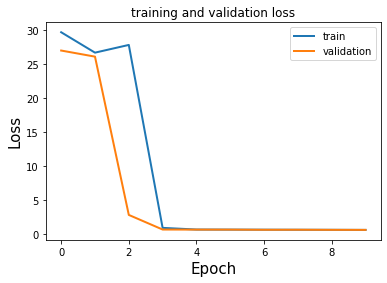

In [49]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

train_loss = np.load('../saved_models/task2/epoch10_0.001/train_loss.npy')
val_loss = np.load('../saved_models/task2/epoch10_0.001/val_loss.npy')
plt.plot(train_loss, linewidth=2, label='train')
plt.plot(val_loss, linewidth=2, label='validation')
plt.xlabel('Epoch', fontsize=15)
plt.ylabel('Loss', fontsize=15)
plt.legend()
plt.title('training and validation loss')

val accuracy: 0.6302083
train accuracy: 0.61869264


Text(0.5, 1.0, 'training and validation Accuracy')

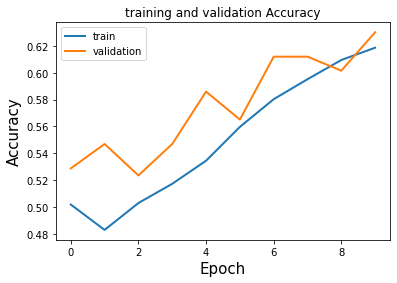

In [58]:
val_acc = np.load('../saved_models/task2/epoch10_0.001/val_acc.npy')
train_acc = np.load('../saved_models/task2/epoch10_0.001/train_acc.npy')
print('val accuracy:', val_acc[-1])
print('train accuracy:', train_acc[-1])
plt.plot(train_acc, linewidth=2, label='train')
plt.plot(val_acc, linewidth=2, label='validation')
plt.xlabel('Epoch', fontsize=15)
plt.ylabel('Accuracy', fontsize=15)
plt.legend()
plt.title('training and validation Accuracy')

labels shape (371,)
pred shape (371,)


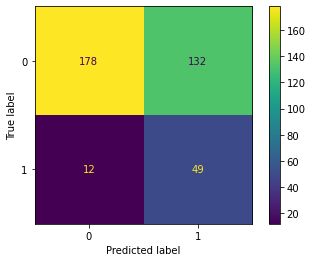

In [50]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, f1_score, recall_score, roc_curve, auc
from sklearn.preprocessing import label_binarize
test_labels = np.array(test_labels)
test_pred = np.array(test_pred)
print('labels shape', test_labels.shape)
print('pred shape', test_pred.shape)
cm = confusion_matrix(test_pred, test_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

In [67]:
def wrong_and_right(net, test_data_loader, device):
    net = net.to(device)
    test_steps = len(test_data_loader)
    t_acc=0
    wrong = 0 
    right = 0 
    for i, data in enumerate(test_data_loader): # iterate over batches
    # get image and labels data is in tuple form (inputs, label)
        img1,img2, labels = data
        img1 = img1.to(device)
        img2 = img2.to(device)
        labels = labels.to(device).float()
        net.eval()
        torch.no_grad()   
        outputs = net(img1,img2)
        pred = torch.tensor([1 if y > 0.5 else 0 for y in outputs])
        t_acc = torch.sum(pred == labels)
        if t_acc <16:
            for i in range(0,16):
                if pred[i] != labels[i] and wrong == 0:
                    print('prediction: ', pred[i])
                    print('label: ', labels[i])
                    wrong = 1
                    f, ax = plt.subplots(1,2)
                    ax[0].imshow(img1[i].permute(1, 2, 0))
                    ax[1].imshow(img2[i].permute(1, 2, 0))
                    #plt.imshow(np.transpose(img1*255, (1,2,0)).astype(np.uint8))
                    plt.show()
                if pred[i] == labels[i] and right == 0:
                    print('prediction: ', pred[i])
                    print('label: ', labels[i])
                    right = 1
                    f, ax = plt.subplots(1,2)
                    ax[0].imshow(img1[i].permute(1, 2, 0))
                    ax[1].imshow(img2[i].permute(1, 2, 0))
                    #plt.imshow(np.transpose(img1*255, (1,2,0)).astype(np.uint8))
                    plt.show()
                if wrong ==1 and right==1:
                    return 1

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


prediction:  tensor(1)
label:  tensor(0.)


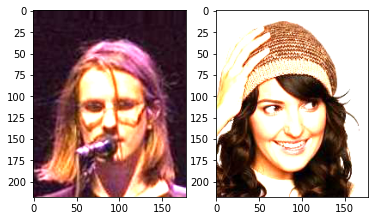

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


prediction:  tensor(1)
label:  tensor(1.)


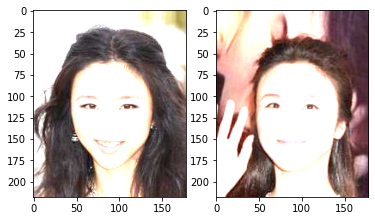

In [68]:
path = '../saved_models/task2/epoch1/task2.pt'
net = Net().to(device)
net.load_state_dict(torch.load(path))
a = wrong_and_right(net,test_data_loader, device)